In [ ]:
pip install requests beautifulsoup4 robustbase


In [1]:
import requests
from bs4 import BeautifulSoup
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import numpy as np
from sklearn.preprocessing import MinMaxScaler



In [3]:
import json
import pandas as pd
import re

df = pd.read_csv("B:/tut-pricing-model\Makeup Essentials Scrape - Copy of Sheet1.csv", encoding="utf-8")


df = df.dropna(subset=["Price"])
import time


# Define the function to scrape the brand name
def scrape_brand_name(session, url):
    try:
        if not url or not url.startswith("http"):  # Validate URL
            return None

        # Send a GET request to the URL using the session
        response = session.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP issues

        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(response.content, "html.parser")

        # Adjust this selector based on the actual structure of the webpage
        brand_tag = soup.find("tr", class_="a-spacing-small po-brand")
        if brand_tag:
            td_tag = brand_tag.find("td", class_="a-span9")
            if td_tag:
                span_tag = td_tag.find("span", class_="a-size-base po-break-word")
                if span_tag:
                    return span_tag.get_text(strip=True)

        # Return None if the brand name is not found
        return None

    except requests.exceptions.RequestException as e:
        print(f"Network error scraping {url}: {e}")
        return None
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

# Load the JSON file

"""
# Ensure the 'link' column exists and is valid
if "link" in df.columns:
    # Create a requests session
    with requests.Session() as session:
        # Set a User-Agent header to mimic a browser (optional but recommended)
        session.headers.update({
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
        })

        # Apply the scraping function to the 'link' column
        brand_names = []
        for idx, url in enumerate(df["link"]):
            print(f"Scraping {idx + 1}/{len(df)}: {url}")
            brand_name = scrape_brand_name(session, url)
            brand_names.append(brand_name)

            # Throttle requests to avoid getting blocked
            time.sleep(2)

        # Add the scraped brand names to the DataFrame
        df["brand_name"] = brand_names"""




def extract_volume(title_str):
    # Check for "ml" first to avoid misidentification
    match_ml = re.search(r'(\d+(?:\.\d+)?)\s*ml', title_str, re.IGNORECASE)
    if match_ml:
        return float(match_ml.group(1))  # Prioritize ml if present
    else:
    # Check for "oz" (fluid ounces)
      match_oz = re.search(r'(\d+(?:\.\d+)?)\s*(?:fl\.?\s*oz|oz|fluid ounces?)', title_str, re.IGNORECASE)
      if match_oz:
         return float(match_oz.group(1)) * 29.5735  # Convert oz to ml

    # If no match, return None
    return None

# Apply the function to the DataFrame
df["volume"] = df["Product Name"].apply(extract_volume)

def remove_duplicates_by_name_and_price(df):
    # Sort the DataFrame to keep the first occurrence of each duplicate
    df = df.sort_values(by=["Product Name", "Price"])

    # Drop duplicates based on 'name' and 'price_numeric'
    df = df.drop_duplicates(subset=["Product Name", "Price"], keep="first")

    return df

# Apply the duplicate removal function to the DataFrame
df = remove_duplicates_by_name_and_price(df)



<>:5: SyntaxWarning: invalid escape sequence '\M'
<>:5: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Basmala Kamal\AppData\Local\Temp\ipykernel_25264\275069771.py:5: SyntaxWarning: invalid escape sequence '\M'
  df = pd.read_csv("B:/tut-pricing-model\Makeup Essentials Scrape - Copy of Sheet1.csv", encoding="utf-8")


In [4]:
print(df["Product type"].unique())


['Foundation ' 'Highlighter ' 'Lipstick' 'Tint' 'Concealer']


In [5]:
print(df["Product type"].value_counts(dropna=False))


Product type
Lipstick        1557
Foundation      1038
Concealer        554
Highlighter      306
Tint             281
Name: count, dtype: int64


In [6]:
df_concealer = df[df["Product type"].str.strip().str.lower() == "concealer"]
print(df_concealer[["Product Name", "volume", "Price"]])
print(df_concealer.shape)


                                           Product Name  volume    Price
3547      ANASTASIA BEVERLY HILLS Magic Touch Concealer     NaN   152.00
3580                 ANASTASIA BEVERLY HILLS Pro Pencil     NaN   109.00
3570  ARMANI Luminous Silk Multi-Purpose Glow Concealer     NaN   248.00
3573                      ARMANI Power Fabric Concealer     NaN   242.00
3599  ARMANI Power Fabric High Coverage Stretchable ...     NaN   242.00
...                                                 ...     ...      ...
313   tarte Original Shape Tape™ Concealer, Contour ...    10.0   266.88
310   tarte Original Shape Tape™ Concealer, Contour ...    10.0   266.88
245                  tarte Shape Tape Contour Concealer     NaN      134
235            tarte shape tape full-coverage concealer     NaN      127
263     tarte shape tape glow wand - alight (opal glow)     NaN    161.4

[554 rows x 3 columns]
(554, 8)


In [8]:
def is_multi_item(title):
    title = title.lower()

    # Case 1: 'Set' and 'Pieces'
    if "set" in title and "pieces" in title or "bundle" in title or "pack" in title:
        return True

    # Case 2: '2-pack', 'two-pack', '2 bottles', 'two bottles'
    if re.search(r'(2-pack|two-pack|2 bottles|two bottles|two items|two)', title, re.IGNORECASE):
        return True

    # Case 3: '3 bottles', '4 pack', '5 count', etc.
    if re.search(r'\b\d+\s*(?:bottles|packs?|count)\b', title, re.IGNORECASE):
        return True

    return False

# Create a mask for sets
mask_sets = df_concealer["Product Name"].apply(is_multi_item)

# Split the DataFrame
sets_df_concealer = df_concealer[mask_sets].copy()
df_concealer = df_concealer[~mask_sets].copy()

# Optional: Reset index if needed
sets_df_concealer.reset_index(drop=True, inplace=True)
df_concealer.reset_index(drop=True, inplace=True)

In [9]:
df_concealer["Price"] = df_concealer["Price"].replace(r"[^\d.]", "", regex=True).astype(float)


In [ ]:
"""df_concealer["volume_per_price"] = np.where(
    (df_concealer["volume"].notna()) &
    (df_concealer["Price"].notna()) &
    (df_concealer["Price"] > 0),
    df_concealer["volume"] / df_concealer["Price"],
    np.nan
)
"""

'df_concealer["volume_per_price"] = np.where(\n    (df_concealer["volume"].notna()) &\n    (df_concealer["Price"].notna()) &\n    (df_concealer["Price"] > 0),\n    df_concealer["volume"] / df_concealer["Price"],\n    np.nan\n)\n'

In [10]:
print(df_concealer["Price"].describe())


count     519.000000
mean      104.573121
std        93.214444
min         3.950000
25%        53.680000
50%        77.950000
75%       150.000000
max      1217.000000
Name: Price, dtype: float64


In [11]:
#print(df_concealer["volume_per_price"].describe())


In [ ]:
"""import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_concealer["volume_per_price"].dropna(), bins=30, kde=True)
plt.title("Volume per Price Distribution - Concealers (Full Range)")
plt.xlabel("Volume per Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
"""

In [ ]:
"""df_concealer = df_concealer.dropna(subset=["Product Name", "volume_per_price"])
df_cleaned.shape"""

In [ ]:
"""import numpy as np
from sklearn.preprocessing import StandardScaler

# Apply log transformation
df_cleaned["price_log"] = np.log1p(df_cleaned["volume_per_price"])

# Then standard scale
scaler = StandardScaler()
df_cleaned["price_scaled"] = scaler.fit_transform(df_cleaned[["price_log"]])"""

In [ ]:
"""from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# 2. Feature for clustering
X_price = df_cleaned[["price_scaled"]].values

# 3. Plot setup
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 4. Try multiple cluster counts
for idx, k in enumerate([2, 3, 4, 5]):
    if len(df_cleaned) < k:
        print(f"Skipping k={k} due to insufficient data.")
        continue

    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)

    # Add cluster labels to DataFrame
    cluster_col = f"cluster_k{k}"
    df_cleaned[cluster_col] = kmeans.labels_

    # Silhouette score
    if len(set(kmeans.labels_)) > 1:
        sil_score = silhouette_score(X_price, kmeans.labels_)
    else:
        sil_score = np.nan

    # Boxplot using raw prices, grouped by cluster
    sns.boxplot(
        x=cluster_col,
        y="price_scaled",  # Show real prices
        data=df_cleaned,
        ax=axes[idx]
    )
    axes[idx].set_title(f"K={k} (Silhouette={sil_score:.2f})")
    axes[idx].set_xlabel("Cluster")
    axes[idx].set_ylabel("Price (SAR)")

# Final plot formatting
plt.suptitle("KMeans Clustering on Price (using Scaled Prices for Clustering)", fontsize=16)
plt.tight_layout()
plt.show()
"""

In [ ]:
"""from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract scaled price for clustering
X_price = df_cleaned[["price_scaled"]].values

# Elbow Method: Try k from 2 to 5
distortions = []
K_range = range(1, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, 'bx-')
plt.title('Elbow Method for Scaled Prices (All Data)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.xticks(K_range)
plt.grid(True)
plt.show()
"""

In [ ]:
"""import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# 1. Extract price_scaled values for clustering
X_price = df_cleaned[["price_scaled"]].values

# 2. Run KMeans with k=3
k = 2
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)

# 3. Assign cluster labels back to df_cleaned
df_cleaned = df_cleaned.copy()  # optional: avoid modifying original
df_cleaned["final_cluster"] = kmeans.labels_

# 4. Show actual price statistics per cluster
summary = (
    df_cleaned
    .groupby("final_cluster")["Price"]
    .agg(["count", "mean", "min", "max"])
    .sort_index()
)

print("Cluster Summary Based on Actual Prices (SAR):")
print(summary)
"""

In [12]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Apply log transformation
df_concealer["price_log"] = np.log1p(df_concealer["Price"])

# Then standard scale
scaler = StandardScaler()
df_concealer["price_scaled"] = scaler.fit_transform(df_concealer[["price_log"]])

C:\Users\Basmala Kamal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Basmala Kamal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 

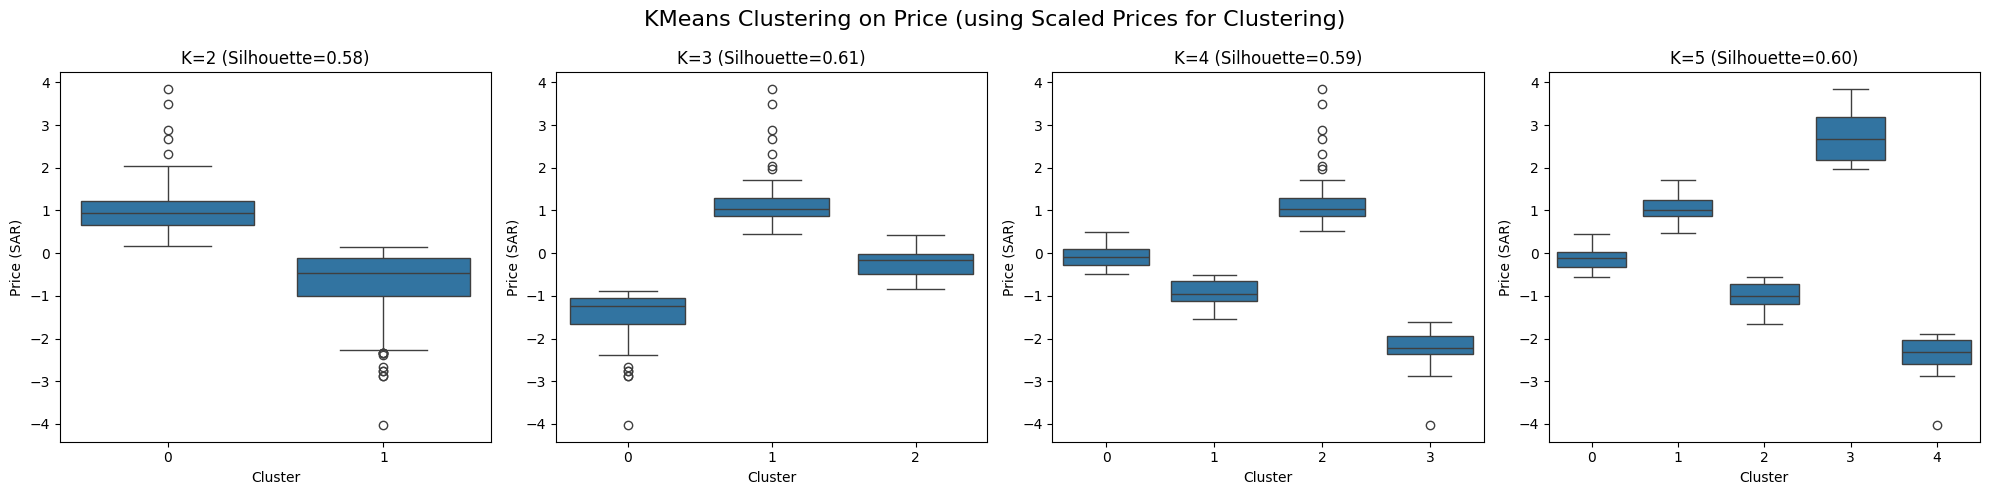

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# 2. Feature for clustering
X_price = df_concealer[["price_scaled"]].values

# 3. Plot setup
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 4. Try multiple cluster counts
for idx, k in enumerate([2, 3, 4, 5]):
    if len(df_concealer) < k:
        print(f"Skipping k={k} due to insufficient data.")
        continue

    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)

    # Add cluster labels to DataFrame
    cluster_col = f"cluster_k{k}"
    df_concealer[cluster_col] = kmeans.labels_

    # Silhouette score
    if len(set(kmeans.labels_)) > 1:
        sil_score = silhouette_score(X_price, kmeans.labels_)
    else:
        sil_score = np.nan

    # Boxplot using raw prices, grouped by cluster
    sns.boxplot(
        x=cluster_col,
        y="price_scaled",  # Show real prices
        data=df_concealer,
        ax=axes[idx]
    )
    axes[idx].set_title(f"K={k} (Silhouette={sil_score:.2f})")
    axes[idx].set_xlabel("Cluster")
    axes[idx].set_ylabel("Price (SAR)")

# Final plot formatting
plt.suptitle("KMeans Clustering on Price (using Scaled Prices for Clustering)", fontsize=16)
plt.tight_layout()
plt.show()


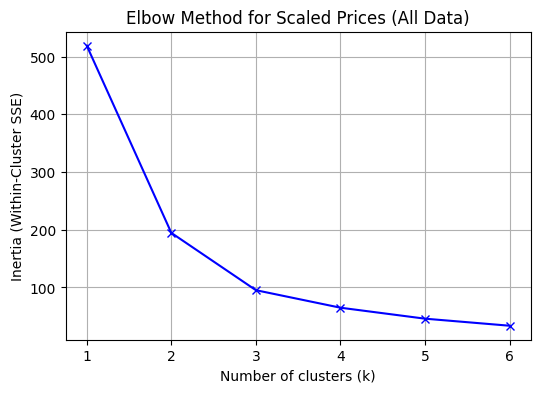

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract scaled price for clustering
X_price = df_concealer[["price_scaled"]].values

# Elbow Method: Try k from 2 to 5
distortions = []
K_range = range(1, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, 'bx-')
plt.title('Elbow Method for Scaled Prices (All Data)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.xticks(K_range)
plt.grid(True)
plt.show()


In [15]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# 1. Extract price_scaled values for clustering
X_price = df_concealer[["price_scaled"]].values

# 2. Run KMeans with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)

# 3. Assign cluster labels back to df_cleaned
df_concealer = df_concealer.copy()  # optional: avoid modifying original
df_concealer["final_cluster"] = kmeans.labels_

# 4. Show actual price statistics per cluster
summary = (
    df_concealer
    .groupby("final_cluster")["Price"]
    .agg(["count", "mean", "min", "max"])
    .sort_index()
)

print("Cluster Summary Based on Actual Prices (SAR):")
print(summary)


Cluster Summary Based on Actual Prices (SAR):
               count        mean     min      max
final_cluster                                    
0                 90   30.273000    3.95    43.25
1                172  192.584477  113.00  1217.00
2                257   71.690078   45.00   111.00


In [16]:
low = df_concealer[
    (df_concealer["final_cluster"] == 0)
]
low

,Unnamed: 0,Website,Product type,Product Link,Product Img,Product Name,Price,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
5,NaN,Noon,Concealer,https://www.noon.com/saudi-en/4-colour-conceal...,https://f.nooncdn.com/p/pzsku/Z5F16653360860B7...,ARTLOOK 4-Colour Concealer,3.95,NaN,1.599388,-4.024494,1,0,3,4,0
37,NaN,Amazon,Concealer,https://www.amazon.sa/-/en/Bourjois-Always-Fab...,https://m.media-amazon.com/images/I/614JDQNYU+...,"Bourjois Always Fabulous Sculptor Concealer, 3...",40.49,10.0,3.725452,-0.985996,1,0,1,2,0
38,NaN,Amazon,Concealer,https://www.amazon.sa/-/en/Bourjois-Always-Fab...,https://m.media-amazon.com/images/I/61XC0MvcRL...,"Bourjois Always Fabulous Sculptor Concealer, 4...",40.50,10.0,3.725693,-0.985651,1,0,1,2,0
44,NaN,Amazon,Concealer,https://www.amazon.sa/-/en/Bourjois-Healthy-Cl...,https://m.media-amazon.com/images/I/61TUVrzkXH...,Bourjois Healthy Mix Clean Concealer - Skin Ev...,39.50,6.0,3.701302,-1.020511,1,0,1,2,0
45,NaN,Nahdi,Concealer,https://www.nahdionline.com/en-sa/bourjois-kho...,https://ecombe.nahdionline.com/media/catalog/p...,Bourjois Khol & Contour 002 Ultra - Black,27.29,NaN,3.342508,-1.533286,1,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,NaN,Amazon,Concealer,https://www.amazon.sa/-/en/l-f-Studio-Conceale...,https://m.media-amazon.com/images/I/51fX9+ifq2...,e.l.f. Elf Studio Concealer Ivor Size .11z Elf...,39.00,NaN,3.688879,-1.038264,1,0,1,2,0
504,NaN,Amazon,Concealer,https://www.amazon.sa/-/en/CAMOUFLAGE-conceale...,https://m.media-amazon.com/images/I/41ECr7Z4IA...,"essence CAMOUFLAGE+ HEALTHY GLOW concealer, co...",36.64,5.0,3.628067,-1.125175,1,0,1,2,0
506,NaN,Amazon,Concealer,https://www.amazon.sa/-/en/brightening-Nourish...,https://m.media-amazon.com/images/I/51bcMDJ7tG...,"essence Multitask Concealer, Concealer, no. 20...",19.01,3.0,2.996232,-2.028172,1,0,3,4,0
507,NaN,Amazon,Concealer,https://www.amazon.sa/-/en/brightening-Nourish...,https://m.media-amazon.com/images/I/51Gk1PpJCg...,"essence Multitask Concealer, No. 10 Peachy Ivo...",16.86,3.0,2.882564,-2.190623,1,0,3,4,0


In [17]:
mid = df_concealer[
    (df_concealer["final_cluster"] == 2)
]
mid

,Unnamed: 0,Website,Product type,Product Link,Product Img,Product Name,Price,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
1,NaN,Sephora,Concealer,https://www.sephora.me/sa-en/p/pro-pencil/P267...,https://img-product.sephora.me/dw/image/v2/BKW...,ANASTASIA BEVERLY HILLS Pro Pencil,109.00,NaN,4.700480,0.407480,0,2,0,0,2
10,NaN,Sephora,Concealer,https://www.sephora.me/sa-en/p/lovetint-lip-%2...,https://img-product.sephora.me/dw/image/v2/BKW...,BENEFIT COSMETICS Lovetint Lip & Cheek Stain,111.00,NaN,4.718499,0.433232,0,2,0,0,2
14,NaN,Noon,Concealer,https://www.noon.com/saudi-en/always-fabulous-...,NaN,BOURJOIS PARIS Always Fabulous The Sculptor Co...,47.00,NaN,3.871201,-0.777697,1,2,1,2,2
15,NaN,Noon,Concealer,https://www.noon.com/saudi-en/healthy-mix-2-in...,NaN,BOURJOIS PARIS Healthy Mix 2-in-1 Serum Concea...,87.00,13.0,4.477337,0.088571,1,2,0,0,2
16,NaN,Noon,Concealer,https://www.noon.com/saudi-en/healthy-mix-2-in...,NaN,BOURJOIS PARIS Healthy Mix 2-in-1 Serum Concea...,87.00,13.0,4.477337,0.088571,1,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,NaN,Amazon,Concealer,https://www.amazon.sa/-/en/essence-Camouflage-...,https://m.media-amazon.com/images/I/41pb795B6l...,"essence Camouflage+ Matte Concealer, Masking P...",56.80,5.0,4.056989,-0.512175,1,2,1,0,2
509,NaN,Noon,Concealer,https://www.noon.com/saudi-en/perfect-coverage...,https://f.nooncdn.com/p/v1607148940/N42746884A...,flormar Perfect Coverage Concealer Liquid Soft...,64.95,NaN,4.188897,-0.323657,1,2,0,0,2
510,NaN,Noon,Concealer,https://www.noon.com/saudi-en/perfect-coverage...,https://f.nooncdn.com/p/v1604559638/N38125896A...,flormar Perfect Coverage Liquid Concealer Fair...,55.00,NaN,4.025352,-0.557390,1,2,1,2,2
511,NaN,Noon,Concealer,https://www.noon.com/saudi-en/stay-perfect-liq...,https://f.nooncdn.com/p/pnsku/N70081911V/45/_/...,flormar Stay Perfect Liquid Concealer - 010 To...,57.00,NaN,4.060443,-0.507239,1,2,1,0,2


In [18]:
high = df_concealer[
    (df_concealer["final_cluster"] == 1)
]
high

,Unnamed: 0,Website,Product type,Product Link,Product Img,Product Name,Price,volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
0,NaN,Sephora,Concealer,https://www.sephora.me/sa-en/p/magic-touch-con...,https://img-product.sephora.me/dw/image/v2/BKW...,ANASTASIA BEVERLY HILLS Magic Touch Concealer,152.00,NaN,5.030438,0.879044,0,1,2,1,1
2,NaN,Sephora,Concealer,https://www.sephora.me/sa-en/p/luminous-silk-m...,https://img-product.sephora.me/dw/image/v2/BKW...,ARMANI Luminous Silk Multi-Purpose Glow Concealer,248.00,NaN,5.517453,1.575069,0,1,2,1,1
3,NaN,Sephora,Concealer,https://www.sephora.me/sa-en/p/power-fabric-co...,https://img-product.sephora.me/dw/image/v2/BKW...,ARMANI Power Fabric Concealer,242.00,NaN,5.493061,1.540210,0,1,2,1,1
4,NaN,Sephora,Concealer,https://www.sephora.me/sa-en/p/power-fabric-hi...,https://img-product.sephora.me/dw/image/v2/BKW...,ARMANI Power Fabric High Coverage Stretchable ...,242.00,NaN,5.493061,1.540210,0,1,2,1,1
6,NaN,Noon,Concealer,https://www.noon.com/saudi-en/ultimate-coverag...,https://f.nooncdn.com/p/v1616071822/N30652759A...,BECCA Ultimate Coverage Longwear Concealer Sesame,175.50,NaN,5.173321,1.083248,0,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,NaN,Amazon,Concealer,https://www.amazon.sa/-/en/tarte-Creaseless-Un...,https://m.media-amazon.com/images/I/71zjROjDas...,"tarte Creaseless Undereye Concealer, 0.225 Oz ...",152.81,6.654038,5.035718,0.886590,0,1,2,1,1
515,NaN,Amazon,Concealer,https://www.amazon.sa/-/en/tarte-Double-Beauty...,https://m.media-amazon.com/images/I/61PqpKlqSh...,tarte Double Duty Beauty Shape Tape Contour Co...,132.00,NaN,4.890349,0.678834,0,1,2,1,1
516,NaN,Amazon,Concealer,https://www.amazon.sa/-/en/tarte-Shape-Tape-Co...,https://m.media-amazon.com/images/I/61wOGnWVrS...,tarte Shape Tape Contour Concealer,134.00,NaN,4.905275,0.700165,0,1,2,1,1
517,NaN,Amazon,Concealer,https://www.amazon.sa/-/en/tarte-shape-tape-fu...,https://m.media-amazon.com/images/I/61oOmn2Cft...,tarte shape tape full-coverage concealer,127.00,NaN,4.852030,0.624070,0,1,2,1,1
